In [68]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, RationalQuadratic
from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from skopt.space import Categorical


from sklearn.metrics import mean_squared_error, r2_score

data_dir = 'data'

In [69]:
df = pd.read_csv(os.path.join(data_dir, 'final_data.csv'))

df.head()

,TAU_bl,PTAU_bl,ABETA_bl,PTEDUCAT,MMSE_bl,EcogPtTotal_bl,LDELTOTAL_BL,mPACCdigit_bl,mPACCtrailsB_bl,RAVLT_immediate_bl,...,SUVr_Vermis_1_2.nii,SUVr_Vermis_3.nii,SUVr_Vermis_4_5.nii,SUVr_Vermis_6.nii,SUVr_Vermis_7.nii,SUVr_Vermis_8.nii,SUVr_Vermis_9.nii,SUVr_Vermis_10.nii,SUVr_VTA_L.nii,SUVr_VTA_R.nii
0,101.2,10.08,731.8,-1.0,-2.0,-0.179246,15.0,1.722587,1.525525,0.440843,...,0.003369,0.011351,0.030880,0.018253,0.009289,0.011917,0.008881,0.006231,0.000712,0.000659
1,324.8,34.39,780.3,-2.0,-3.0,0.216812,7.0,0.221907,0.032151,0.582690,...,0.003325,0.011246,0.029007,0.016903,0.009108,0.012666,0.008033,0.006029,0.000770,0.000699
2,490.4,53.18,832.7,0.5,0.5,-0.275793,3.0,-1.111149,-1.035326,-0.784427,...,0.003402,0.011694,0.033622,0.019224,0.010413,0.012902,0.007799,0.005730,0.000804,0.000760
3,108.2,10.55,590.4,3.0,3.0,-0.545607,11.0,0.306061,0.339234,0.002003,...,0.003367,0.011986,0.034076,0.019834,0.010011,0.012782,0.009789,0.006613,0.000748,0.000675
4,247.1,24.78,466.1,1.0,0.5,0.040211,18.0,1.883734,1.336483,0.512023,...,0.002935,0.009448,0.028740,0.017897,0.009361,0.012595,0.008533,0.005170,0.000675,0.000675


# Predict ABETA baseline 

Features are cog scores and pet suvr's
Drop the other CSF from the features
Target is ABETA_bl


### Data set-up


<Axes: xlabel='PTAU_bl', ylabel='Count'>

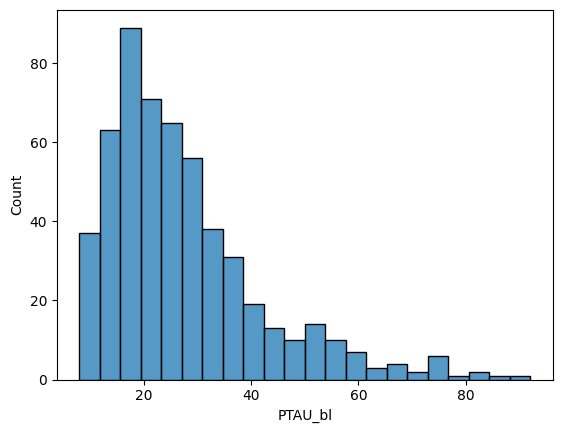

In [70]:
sns.histplot(df['PTAU_bl'])

<Axes: xlabel='PTAU_bl', ylabel='Count'>

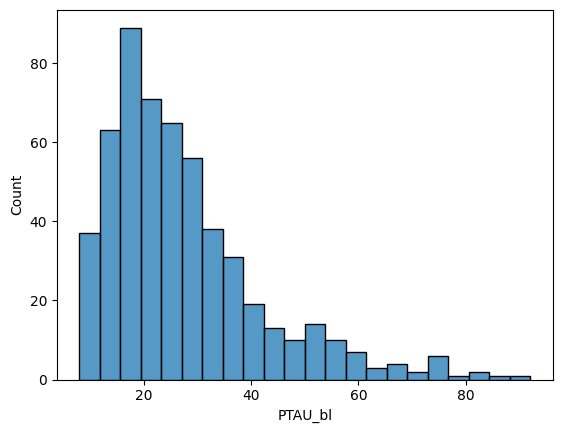

In [71]:


sns.histplot(df['PTAU_bl'])

In [ ]:
X = df.drop(columns = ['ABETA_bl', 'TAU_bl', 'PTAU_bl'], axis = 1)
y = df['ABETA_bl']

scaler = StandardScaler()


X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(434, 175) (109, 175) (434,) (109,)


### Model set up

length scale places importance on different features

In [48]:

kernel = 1 * RBF(length_scale= 1e1, 
                 length_scale_bounds = (1e1, 1e3))

gpr = GaussianProcessRegressor(kernel=kernel,
                               alpha = 5e-1,
                               n_restarts_optimizer= 10,
                               random_state=42,
                               normalize_y= True)

gpr.fit(X_train, y_train)

,kernel,1**2 * RBF(length_scale=10)
,alpha,0.5
,optimizer,'fmin_l_bfgs_b'
,n_restarts_optimizer,10
,normalize_y,True
,copy_X_train,True
,n_targets,None
,random_state,42
,kernel__k1,1**2
,kernel__k2,RBF(length_scale=10)
,kernel__k1__constant_value,1


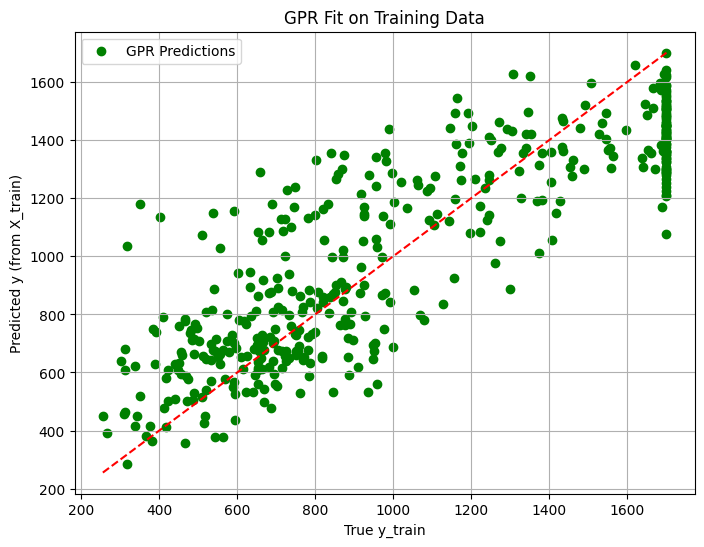

MSE: 57372.98990709088
Rsquared: 0.7215386720804835


In [49]:
y_mean_train, y_std_train = gpr.predict(X_train, return_std= True)

plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_mean_train, color='green', label='GPR Predictions')
plt.plot([y_train.min(), y_train.max()],
         [y_train.min(), y_train.max()],
         'r--') 
plt.xlabel("True y_train")
plt.ylabel("Predicted y (from X_train)")
plt.title("GPR Fit on Training Data")
plt.legend()
plt.grid(True)
plt.show()

mse = mean_squared_error(y_train, y_mean_train)
r2 = r2_score(y_train, y_mean_train)

print(f"MSE: {mse}")
print(f"Rsquared: {r2}")

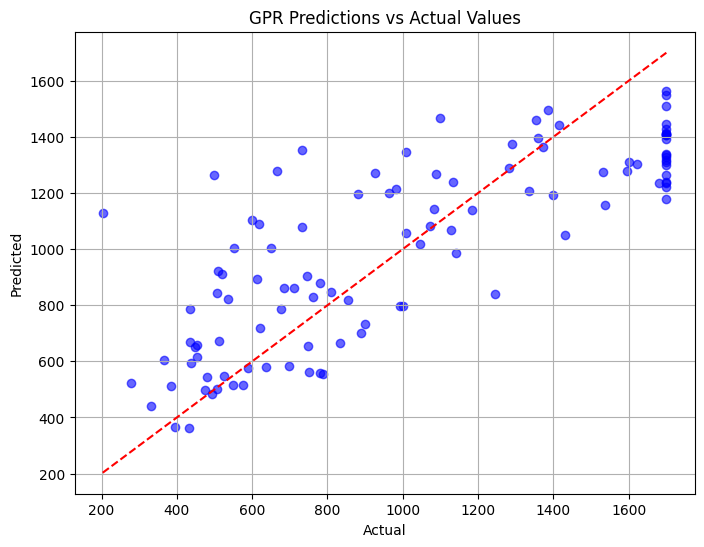

MSE: 83838.36565133276
Rsquared: 0.6313681059265654


In [50]:
y_mean_test, y_std_train = gpr.predict(X_test, return_std= True)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_mean_test, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # reference line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("GPR Predictions vs Actual Values")
plt.grid(True)
plt.show()

mse = mean_squared_error(y_test, y_mean_test)
r2 = r2_score(y_test, y_mean_test)

print(f"MSE: {mse}")
print(f"Rsquared: {r2}")

# Predict pTAU 

In [72]:
X = df.drop(columns = ['ABETA_bl', 'TAU_bl', 'PTAU_bl'], axis = 1)
y = np.log(df['PTAU_bl'])


scaler = StandardScaler()

X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(434, 175) (109, 175) (434,) (109,)


In [73]:
kernel = 1.00 * RationalQuadratic(length_scale= 1e-3,
                                  alpha = 0.01)

gpr = GaussianProcessRegressor(kernel=kernel,
                               alpha = 0.42,
                               n_restarts_optimizer= 30,
                               random_state=42,
                               normalize_y= True)

gpr.fit(X_train, y_train)

c:\Users\huw\OneDrive\Documents\Research_Internship\MPhys_scripts\.conda\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


,kernel,1**2 * Ration...h_scale=0.001)
,alpha,0.42
,optimizer,'fmin_l_bfgs_b'
,n_restarts_optimizer,30
,normalize_y,True
,copy_X_train,True
,n_targets,None
,random_state,42
,kernel__k1,1**2
,kernel__k2,RationalQuadr...h_scale=0.001)
,kernel__k1__constant_value,1.0


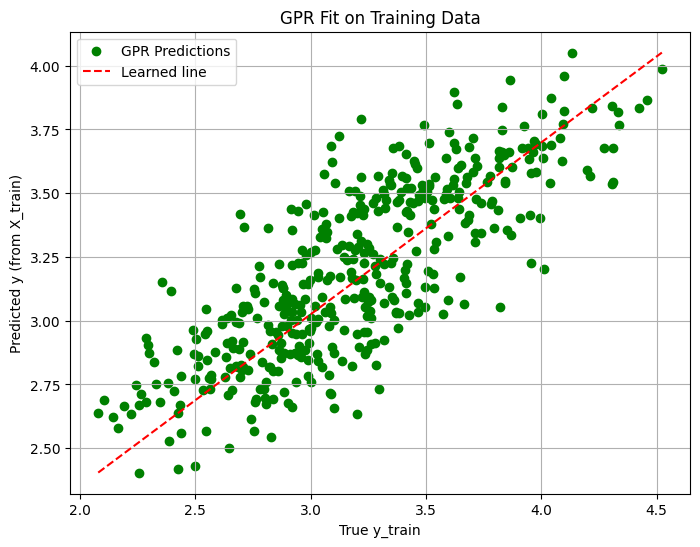

MSE: 0.08776735388646593
Rsquared: 0.6275454483250578


In [74]:
y_mean_train, y_std_train = gpr.predict(X_train, return_std= True)

plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_mean_train, color='green', label='GPR Predictions')
plt.plot([y_train.min(), y_train.max()],
         [y_mean_train.min(), y_mean_train.max()],
         'r--',
         label = 'Learned line') 
plt.xlabel("True y_train")
plt.ylabel("Predicted y (from X_train)")
plt.title("GPR Fit on Training Data")
plt.legend()
plt.grid(True)
plt.show()

mse = mean_squared_error(y_train, y_mean_train)
r2 = r2_score(y_train, y_mean_train)

print(f"MSE: {mse}")
print(f"Rsquared: {r2}")

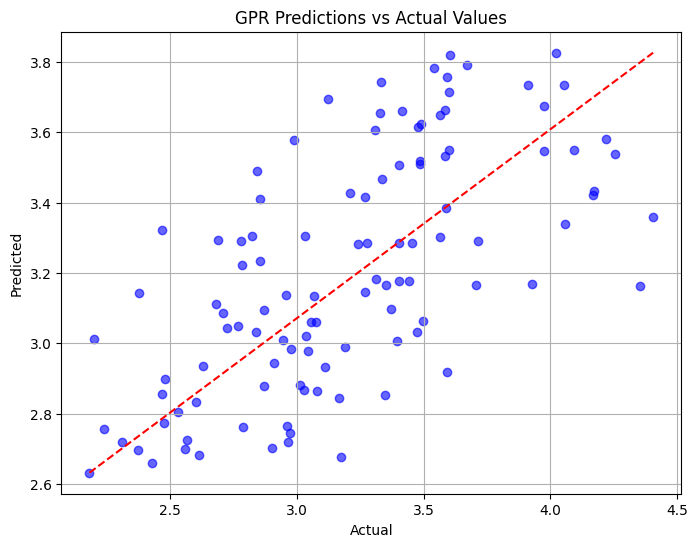

MSE: 0.15322975471560224
Rsquared: 0.419541007096228


In [67]:
y_mean_test, y_std_train = gpr.predict(X_test, return_std= True)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_mean_test, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_mean_test.min(), y_mean_test.max()], 'r--')  # reference line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("GPR Predictions vs Actual Values")
plt.grid(True)
plt.show()

mse = mean_squared_error(y_test, y_mean_test)
r2 = r2_score(y_test, y_mean_test)

print(f"MSE: {mse}")
print(f"Rsquared: {r2}")

In [49]:
length_scales = gpr.kernel_.k2.length_scale

print(length_scales)

55.58663542970171


## BayesSearchCV hyperparameter tuning


In [50]:
def make_kernel(name):
    if name == "RQ_1e-5":
        return RationalQuadratic(length_scale=1e-5)
    elif name == "RQ_1e-4":
        return RationalQuadratic(length_scale=1e-4)
    elif name == "RQ_1e-3":
        return RationalQuadratic(length_scale=1e-3)
    elif name == "RQ_1e-2":
        return RationalQuadratic(length_scale=1e-2)
    elif name == "RQ_1e-1":
        return RationalQuadratic(length_scale=1e-1)
    elif name == "RQ_1e0":
        return RationalQuadratic(length_scale=1e0)
    elif name == "RQ_1e1":
        return RationalQuadratic(length_scale=1e1)
    elif name == "RQ_1e2":
        return RationalQuadratic(length_scale=1e2)
    else:
        raise ValueError(f"Unknown kernel: {name}")


search_params = {
    'kernel': Categorical(["RQ_1e-5", "RQ_1e-4", "RQ_1e-3", "RQ_1e-2", "RQ_1e-1", "RQ_1e0", "RQ_1e1", "RQ_1e2"]),
    'alpha': (1e-5, 1e2, 'log-uniform'),
}

class GPRWrapper(GaussianProcessRegressor):
    def set_params(self, **params):
        if "kernel" in params and isinstance(params["kernel"], str):
            params["kernel"] = make_kernel(params["kernel"])
        
        return super().set_params(**params)

gpr = GPRWrapper(
    kernel=RationalQuadratic(length_scale=1.0), alpha=25e-2, n_restarts_optimizer=10, random_state=42, normalize_y=True
)

search = BayesSearchCV(
    gpr,
    search_params,
    n_iter=50,
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42,
)

search.fit(X_train, y_train)

print(f'Best parameters: {search.best_params_}, Best score: {search.best_score_:.2f}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

c:\Users\huw\OneDrive\Documents\Research_Internship\MPhys_scripts\.conda\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


# Predict TAU

In [55]:
X = df.drop(columns = ['ABETA_bl', 'TAU_bl', 'PTAU_bl'], axis = 1)
y = df['TAU_bl']

length_scales = np.ones(X.columns.shape)*10

scaler = StandardScaler()

rs = np.random.randint(1,60)


X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=rs)

print(f"rs: {rs}")
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

rs: 39
(434, 175) (109, 175) (434,) (109,)


In [56]:
def make_kernel(name):
    if name == "RQ_1e-5":
        return RationalQuadratic(length_scale=1e-5)
    elif name == "RQ_1e-4":
        return RationalQuadratic(length_scale=1e-4)
    elif name == "RQ_1e-3":
        return RationalQuadratic(length_scale=1e-3)
    elif name == "RQ_1e-2":
        return RationalQuadratic(length_scale=1e-2)
    elif name == "RQ_1e-1":
        return RationalQuadratic(length_scale=1e-1)
    elif name == "RQ_1e0":
        return RationalQuadratic(length_scale=1e0)
    elif name == "RQ_1e1":
        return RationalQuadratic(length_scale=1e1)
    elif name == "RQ_1e2":
        return RationalQuadratic(length_scale=1e2)
    else:
        raise ValueError(f"Unknown kernel: {name}")
    


search_params = {
    'kernel': Categorical(["RQ_1e-5", "RQ_1e-4", "RQ_1e-3", "RQ_1e-2", "RQ_1e-1", "RQ_1e0", "RQ_1e1", "RQ_1e2"]),
    'alpha': (1e-5, 1e2, 'log-uniform'),
}

class GPRWrapper(GaussianProcessRegressor):
    def set_params(self, **params):
        if "kernel" in params and isinstance(params["kernel"], str):
            params["kernel"] = make_kernel(params["kernel"])
        
        return super().set_params(**params)

gpr = GPRWrapper(
    kernel=RationalQuadratic(length_scale=1.0), alpha=25e-2, n_restarts_optimizer=10, random_state=42, normalize_y=True
)

search = BayesSearchCV(
    gpr,
    search_params,
    n_iter=50,
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42,
)

search.fit(X_train, y_train)

print(f'Best parameters: {search.best_params_}, Best score: {search.best_score_:.2f}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

c:\Users\huw\OneDrive\Documents\Research_Internship\MPhys_scripts\.conda\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge after 18 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Best parameters: OrderedDict([('alpha', 0.5241276491916264), ('kernel', 'RQ_1e-4')]), Best score: 0.36


c:\Users\huw\OneDrive\Documents\Research_Internship\MPhys_scripts\.conda\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [57]:
kernel = 1.00 * RationalQuadratic(length_scale= 1e-4,
                                  alpha = 0.01)

gpr = GaussianProcessRegressor(kernel=kernel,
                               alpha = 0.52,
                               n_restarts_optimizer= 10,
                               random_state=42,
                               normalize_y= True)

gpr.fit(X_train, y_train)

c:\Users\huw\OneDrive\Documents\Research_Internship\MPhys_scripts\.conda\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


,kernel,1**2 * Ration..._scale=0.0001)
,alpha,0.52
,optimizer,'fmin_l_bfgs_b'
,n_restarts_optimizer,10
,normalize_y,True
,copy_X_train,True
,n_targets,None
,random_state,42
,kernel__k1,1**2
,kernel__k2,RationalQuadr..._scale=0.0001)
,kernel__k1__constant_value,1.0


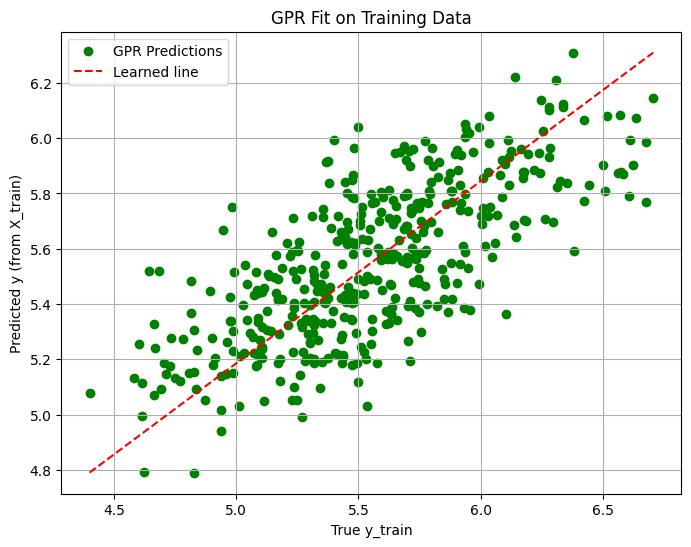

MSE: 0.09361230797936171
Rsquared: 0.5225998808025605


In [58]:
y_mean_train, y_std_train = gpr.predict(X_train, return_std= True)

plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_mean_train, color='green', label='GPR Predictions')
plt.plot([y_train.min(), y_train.max()],
         [y_mean_train.min(), y_mean_train.max()],
         'r--',
         label = 'Learned line') 
plt.xlabel("True y_train")
plt.ylabel("Predicted y (from X_train)")
plt.title("GPR Fit on Training Data")
plt.legend()
plt.grid(True)
plt.show()

mse = mean_squared_error(y_train, y_mean_train)
r2 = r2_score(y_train, y_mean_train)

print(f"MSE: {mse}")
print(f"Rsquared: {r2}")

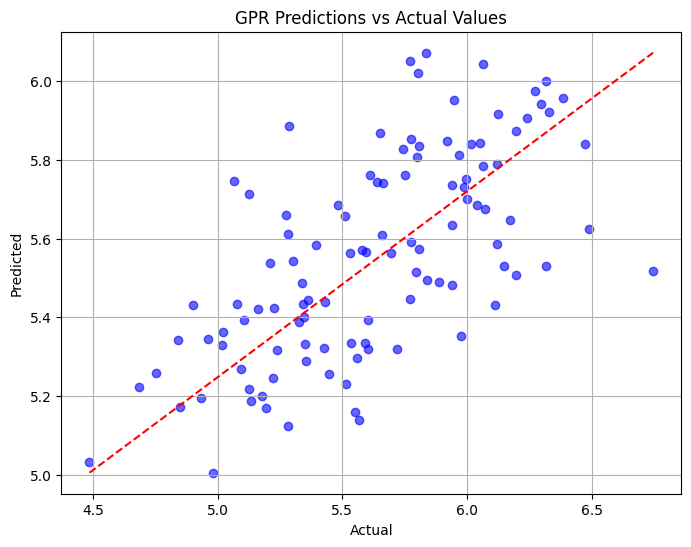

MSE: 0.12333793684043319
Rsquared: 0.39421310939505894


In [59]:
y_mean_test, y_std_train = gpr.predict(X_test, return_std= True)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_mean_test, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_mean_test.min(), y_mean_test.max()], 'r--')  # reference line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("GPR Predictions vs Actual Values")
plt.grid(True)
plt.show()

mse = mean_squared_error(y_test, y_mean_test)
r2 = r2_score(y_test, y_mean_test)

print(f"MSE: {mse}")
print(f"Rsquared: {r2}")

# Predict ABETA with TAU Baseline

In [106]:
X = df.drop(columns = ['ABETA_bl', 'TAU_bl', 'PTAU_bl'], axis = 1)
y = df.filter(['PTAU_bl', 'TAU_bl'])
y['PTAU_bl'] = np.log(y['PTAU_bl'])
y['TAU_bl'] = np.log(y['TAU_bl'])


X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(434, 175) (109, 175) (434, 2) (109, 2)


In [107]:
kernel = 1.00 * RationalQuadratic(length_scale= 1e-1, alpha = 0.01)

gpr = GaussianProcessRegressor(kernel=kernel,
                               alpha = 0.51,
                               n_restarts_optimizer= 30,
                               random_state=42,
                               normalize_y= True)

gpr.fit(X_train, y_train)

c:\Users\huw\OneDrive\Documents\Research_Internship\MPhys_scripts\.conda\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


,kernel,1**2 * Ration...gth_scale=0.1)
,alpha,0.51
,optimizer,'fmin_l_bfgs_b'
,n_restarts_optimizer,30
,normalize_y,True
,copy_X_train,True
,n_targets,None
,random_state,42
,kernel__k1,1**2
,kernel__k2,RationalQuadr...gth_scale=0.1)
,kernel__k1__constant_value,1.0


In [109]:
y_train['PTAU_bl']

334    2.549445
184    3.394844
228    2.931727
542    2.079442
393    2.825537
         ...   
71     3.643359
106    3.341801
270    3.712352
435    3.003204
102    2.945491
Name: PTAU_bl, Length: 434, dtype: float64

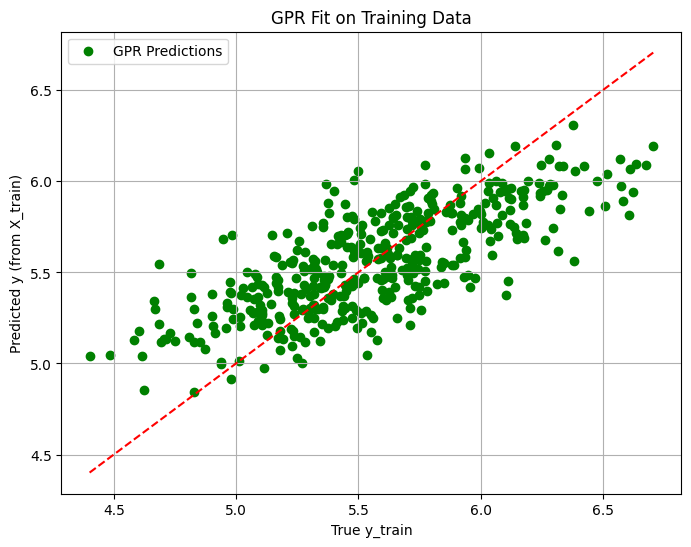

MSE: 0.08493279321173268
Rsquared: 0.5574398405700951


In [113]:
y_mean_train, y_std_train = gpr.predict(X_train, return_std= True)

abeta_y_train = y_train['TAU_bl']

abeta_y_mean_train = y_mean_train[:,1]

plt.figure(figsize=(8, 6))
plt.scatter(abeta_y_train, abeta_y_mean_train, color='green', label='GPR Predictions')
plt.plot([abeta_y_train.min(), abeta_y_train.max()],
         [abeta_y_train.min(), abeta_y_train.max()],
         'r--') 
plt.xlabel("True y_train")
plt.ylabel("Predicted y (from X_train)")
plt.title("GPR Fit on Training Data")
plt.legend()
plt.grid(True)
plt.show()

mse = mean_squared_error(abeta_y_train, abeta_y_mean_train)
r2 = r2_score(abeta_y_train, abeta_y_mean_train)

print(f"MSE: {mse}")
print(f"Rsquared: {r2}")


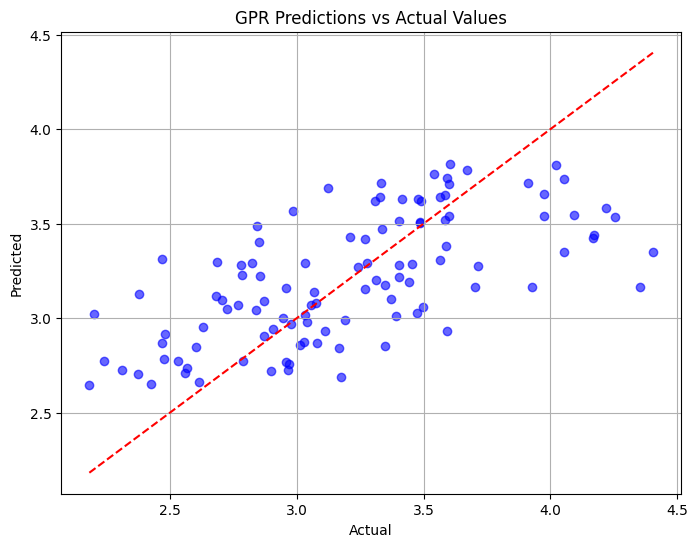

MSE: 0.15269222297172128
Rsquared: 0.4215772639269334


In [114]:
y_mean_test, y_std_train = gpr.predict(X_test, return_std= True)

abeta_y_test = y_test['PTAU_bl']

abeta_y_mean_test = y_mean_test[:,0]

plt.figure(figsize=(8, 6))
plt.scatter(abeta_y_test, abeta_y_mean_test, color='blue', alpha=0.6)
plt.plot([abeta_y_test.min(), abeta_y_test.max()], [abeta_y_test.min(), abeta_y_test.max()], 'r--')  # reference line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("GPR Predictions vs Actual Values")
plt.grid(True)
plt.show()

mse = mean_squared_error(abeta_y_test, abeta_y_mean_test)
r2 = r2_score(abeta_y_test, abeta_y_mean_test)

print(f"MSE: {mse}")
print(f"Rsquared: {r2}")

In [105]:
def make_kernel(name):
    if name == "RQ_1e-5":
        return RationalQuadratic(length_scale=1e-5)
    elif name == "RQ_1e-4":
        return RationalQuadratic(length_scale=1e-4)
    elif name == "RQ_1e-3":
        return RationalQuadratic(length_scale=1e-3)
    elif name == "RQ_1e-2":
        return RationalQuadratic(length_scale=1e-2)
    elif name == "RQ_1e-1":
        return RationalQuadratic(length_scale=1e-1)
    elif name == "RQ_1e0":
        return RationalQuadratic(length_scale=1e0)
    elif name == "RQ_1e1":
        return RationalQuadratic(length_scale=1e1)
    elif name == "RQ_1e2":
        return RationalQuadratic(length_scale=1e2)
    else:
        raise ValueError(f"Unknown kernel: {name}")
    


search_params = {
    'kernel': Categorical(["RQ_1e-5", "RQ_1e-4", "RQ_1e-3", "RQ_1e-2", "RQ_1e-1", "RQ_1e0", "RQ_1e1", "RQ_1e2"]),
    'alpha': (1e-5, 1e2, 'log-uniform'),
}

class GPRWrapper(GaussianProcessRegressor):
    def set_params(self, **params):
        if "kernel" in params and isinstance(params["kernel"], str):
            params["kernel"] = make_kernel(params["kernel"])
        
        return super().set_params(**params)

gpr = GPRWrapper(
    kernel=RationalQuadratic(length_scale=1.0), alpha=25e-2, n_restarts_optimizer=10, random_state=42, normalize_y=True
)

search = BayesSearchCV(
    gpr,
    search_params,
    n_iter=50,
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42,
)

search.fit(X_train, y_train)

print(f'Best parameters: {search.best_params_}, Best score: {search.best_score_:.2f}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

c:\Users\huw\OneDrive\Documents\Research_Internship\MPhys_scripts\.conda\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
